In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
RANDOM_STATE_SEED = 12



In [3]:

X = pd.read_csv('02-14-2018.csv')
X.drop(['Timestamp'], axis=1, inplace=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

In [4]:
y = X.pop('Label')
y.replace(to_replace='Benign', value=0, inplace=True)
y.replace(to_replace=['FTP-BruteForce', 'SSH-Bruteforce'], value=1, inplace=True)
y = y.astype(int)

/var/folders/nm/9cmz0_js4kg04jndp4ql67f00000gn/T/ipykernel_94970/3318677484.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace(to_replace=['FTP-BruteForce', 'SSH-Bruteforce'], value=1, inplace=True)


In [5]:
feature_variances = X.var().sort_values(ascending=False)
top_features = feature_variances.head(12).index
X = X[top_features]

In [6]:
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

In [7]:
X = X[:1000]
y = y[:1000]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE_SEED)


In [12]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9
)

In [13]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(X.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(rate=0.4),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(rate=0.4),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,137 (4.44 KB)

 Trainable params: 1,049 (4.10 KB)

 Non-trainable params: 88 (352.00 B)

In [14]:


early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=3,  # reduced from 5
    restore_best_weights=True
)


In [15]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [16]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7218 - loss: 0.6572 - val_binary_accuracy: 0.9100 - val_loss: 0.3716
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8630 - loss: 0.5039 - val_binary_accuracy: 0.9100 - val_loss: 0.3365
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9041 - loss: 0.4256 - val_binary_accuracy: 0.9100 - val_loss: 0.3389
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8950 - loss: 0.4061 - val_binary_accuracy: 0.9100 - val_loss: 0.3422
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8903 - loss: 0.3978 - val_binary_accuracy: 0.9100 - val_loss: 0.3356


<Axes: title={'center': 'Accuracy'}>

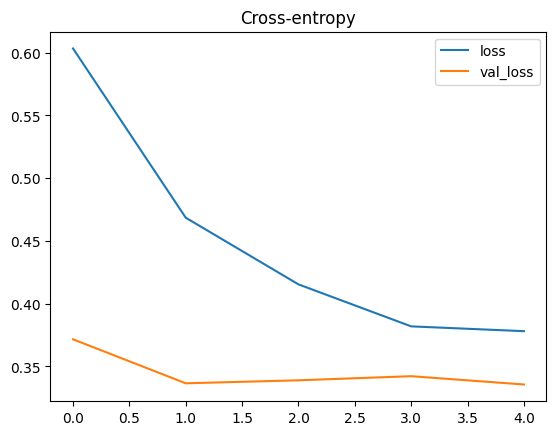

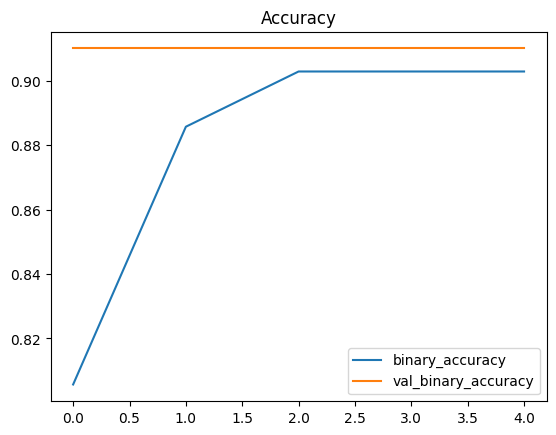

In [17]:
# Plotting
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")


In [18]:
model.save('ddos_model.h5')
